In [39]:
%matplotlib inline

# General libraries
import pandas as pd
import numpy as np
import os
import copy
import warnings
import statsmodels.api as sm
from scipy import stats
import math

# Plotting and printing libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.figure import figaspect
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from itertools import product
import pprint

# Model-building libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler, RobustScaler, Normalizer, scale

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# SK-learn libraries for evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

## Declaring Master Categories, Color Schemes, and Legends

In [32]:
label_names = {'1':'Spruce/Fir', 
               '2':'Lodgepole Pine', 
               '3':'Ponderosa Pine', 
               '4':'Cottonwood/Willow', 
               '5':'Aspen',
               '6':'Douglas Fir',
               '7':'Krummholz'}
'''Plotting helpers'''

color_dict = {1: '#A7C6ED', 2: '#BA0C2F', 3: '#651D32', 4: '#8C8985',
              5: '#212721', 6: '#002F6C', 7: '#FFC000',
              'macro avg': '#473C8B', 'micro avg': '#FF69B4', 'weighted avg': '#228B22',
              '1': '#A7C6ED', '2': '#BA0C2F', '3': '#651D32', '4': '#8C8985',
              '5': '#212721', '6': '#002F6C', '7': '#FFC000',}

marker_dict = {1: ['.', 10], 2: ['.', 10], 3: ['.', 10], 4: ['.', 10],
               5: ['.', 10], 6: ['.', 10], 7: ['.', 10],
              'macro avg': ['v', 16], 'micro avg': ['^', 16], 'weighted avg': ['$W$', 20],
              '1': ['o', 10], '2': ['o', 10], '3': ['o', 10], '4': ['o', 10],
              '5': ['o', 10], '6': ['o', 10], '7': ['o', 10],}

cat_1 = mlines.Line2D([], [], color=color_dict[1], marker=marker_dict[1][0], markersize=marker_dict[1][1], label=label_names['1'])
cat_2 = mlines.Line2D([], [], color=color_dict[2], marker=marker_dict[2][0], markersize=marker_dict[2][1], label=label_names['2'])
cat_3 = mlines.Line2D([], [], color=color_dict[3], marker=marker_dict[3][0], markersize=marker_dict[3][1], label=label_names['3'])
cat_4 = mlines.Line2D([], [], color=color_dict[4], marker=marker_dict[4][0], markersize=marker_dict[4][1], label=label_names['4'])
cat_5 = mlines.Line2D([], [], color=color_dict[5], marker=marker_dict[5][0], markersize=marker_dict[5][1], label=label_names['5'])
cat_6 = mlines.Line2D([], [], color=color_dict[6], marker=marker_dict[6][0], markersize=marker_dict[6][1], label=label_names['6'])
cat_7 = mlines.Line2D([], [], color=color_dict[7], marker=marker_dict[7][0], markersize=marker_dict[7][1], label=label_names['7'])

cat_macro = mlines.Line2D([], [], color=color_dict['macro avg'], marker=marker_dict['macro avg'][0], markersize=marker_dict['macro avg'][1], label='macro avg')
cat_micro = mlines.Line2D([], [], color=color_dict['micro avg'], marker=marker_dict['micro avg'][0], markersize=marker_dict['micro avg'][1], label='micro avg')
cat_weighted = mlines.Line2D([], [], color=color_dict['weighted avg'], marker=marker_dict['weighted avg'][0], markersize=marker_dict['weighted avg'][1], label='weighted avg');

## Defining Modeling Functions
This section defines a set of functions to help process our data, define our models, and assess their performance
+ `apply_scaler` to scale data
+ `cross_validate_model` to cross-validate the models we define
+ `test_model` to generate a summary report of a model's performance

In [3]:
def apply_scaler(scaler, train_data, test_data=None):
    scaled_train_data = scaler.fit_transform(train_data)
    # Quick look to see if it behaved as expected
    scaled_train_df = pd.DataFrame(data=scaled_train_data,    # values
                         columns=train_data.columns)  # 1st row as the column names
    if test_data is not None:
        scaled_test_data = scaler.transform(test_data)
        scaled_test_df = pd.DataFrame(data=scaled_test_data,    # values
                             columns=train_data.columns)  # 1st row as the column names
        return (scaled_train_df, scaled_test_df)
    else:
        return scaled_train_df

In [4]:
def cross_validate_model(model, X, y, name="model", folds=5, verbose=False, return_dict=False, silent=False):
    '''Takes an sklearn or similar model, an X feature set, and a y label set.  
    It performs crossvalidation across n folds and prints the results.'''
    with warnings.catch_warnings(record=False):
        np.random.seed(10)

        reportFields = {'precision': [], 'recall': [], 'f1-score': []}
        generalReport = {'micro avg': copy.deepcopy(reportFields), 
                         'macro avg': copy.deepcopy(reportFields), 
                         'weighted avg':copy.deepcopy(reportFields)}
        for key in label_names:
            generalReport[key] = copy.deepcopy(reportFields)

        skf = StratifiedKFold(n_splits=folds, shuffle=True)
        for train_indexes, valid_indexes in skf.split(X, y):
            foldXTrain, foldYTrain = X.iloc[train_indexes], y.iloc[train_indexes]
            foldXValid, foldYValid = X.iloc[valid_indexes], y.iloc[valid_indexes] 

            model.fit(foldXTrain, foldYTrain)
            foldValidPred = model.predict(foldXValid)
            foldReport = metrics.classification_report(foldValidPred, foldYValid, output_dict=True)

            for key in foldReport:
                for outputField in reportFields:
                    generalReport[key][outputField].append(foldReport[key][outputField])
        if not silent:
            title = name
            if verbose: title += f', with {folds} folds' 
            print(title)

            fields = sorted(generalReport.keys()) if verbose else ['weighted avg']
            fieldLabels = [label_names[field] if field in label_names.keys() else field for field in fields]

            for i in range(len(fields)):
                output = f'\t\t\t{fieldLabels[i]:<20} | '
                for outputField in reportFields:
                    output += f'{outputField}: {np.mean(generalReport[fields[i]][outputField]):>5.2f} | '
                print(output)
            if verbose: print()
        if return_dict: return generalReport

In [5]:
def test_model(model, X_train, y_train, X_test, y_test, name="model", verbose=False, return_dict=False):
    with warnings.catch_warnings(record=False):
        np.random.seed(0)
        
        model.fit(X_train, y_train)
        testPrediction = model.predict(X_test)
        testReport = metrics.classification_report(testPrediction, y_test, output_dict=True)

        print(f'Model: {name}')
        reportFields = ['precision', 'recall', 'f1-score']
        fields = sorted(testReport.keys()) if verbose else ['weighted avg']
        fieldLabels = [label_names[field] if field in label_names.keys() else field for field in fields]
        fieldLabels[-1] = "Final"
        for i in range(len(fields)):
            output = f'\t\t{fieldLabels[i]:<20} | '
            for outputField in reportFields:
                output += f'{outputField}: {np.mean(testReport[fields[i]][outputField]):>5.2f} | '
            print(output)
        if verbose: print()
        if return_dict: return testReport

In [6]:
#Note: Must fit the model prior to running this function
def feat_importance(model, dataColumns, title, featCount=10, mostImportant=True, verbose=False, figsize=(8,3)): 
    # Calculate the feature ranking - Top x 
    importances = model.feature_importances_
    featCount = featCount%len(importances)
    indices = np.argsort(importances)
    if mostImportant: indices = indices[::-1]
    if verbose:
        print (f'{title} Top {featCount} Features\n')
        for f in range(featCount): 
            print("%d. %s (%f)" % (f + 1, dataColumns.columns[indices[f]], importances[indices[f]])) 
        #Mean Feature Importance 
        print ("\nMean Feature Importance %.6f" %np.mean(importances))
    #Plot the feature importances of the forest 
    indices=indices[:featCount] 
    plt.figure(figsize=figsize) 
    plt.title(f'{title} Top {featCount} Features') 
    plt.bar(range(featCount), importances[indices], color="gb", align="center") 
    plt.xticks(range(featCount), dataColumns.columns[indices], fontsize=12, rotation=90) 
    plt.xlim([-1, featCount]) 
    plt.show()

In [7]:
def generate_kaggle_submission(model):
    train_data = pd.read_csv('./train.csv')
    test_features = pd.read_csv('./test.csv')
    test_ids = test_features[['Id']]
    test_features = test_features.drop('Id', axis=1)
    train_labels = train_data['Cover_Type']
    train_features = train_data.drop(['Id', 'Cover_Type'], axis=1)
    
    train_features = apply_engineered_features(train_features)
    test_features = apply_engineered_features(test_features)
    
    model.fit(train_features, train_labels)
    predictions = pd.DataFrame(model.predict(test_features))
    results = pd.concat([test_ids, predictions], axis=1)
    results.to_csv("for_kaggle.csv", index=False, header=['Id', 'Cover_Type'])
    
def apply_engineered_features(data):
    engineered_features = pd.DataFrame.copy(data)
    
    engineered_features = engineered_features.drop(['Soil_Type7', 'Soil_Type15'], axis=1)
    # Replacing Hillshade_9am and Hillshade_3pm 0 values with median
    median_hillshade_9am = np.median(engineered_features['Hillshade_9am'])
    engineered_features['Hillshade_9am'] = engineered_features.apply(lambda row: median_hillshade_9am if row.Hillshade_9am == 0 else row.Hillshade_9am, axis=1)
    median_hillshade_3pm = np.median(engineered_features['Hillshade_3pm'])
    engineered_features['Hillshade_3pm'] = engineered_features.apply(lambda row: median_hillshade_3pm if row.Hillshade_3pm == 0 else row.Hillshade_3pm, axis=1)
    engineered_features['Euclidean_Distance_To_Hydrology'] = engineered_features.apply(lambda row: math.sqrt(row.Horizontal_Distance_To_Hydrology**2 + row.Vertical_Distance_To_Hydrology**2), axis=1)
    engineered_features['Elevation_Of_Hydrology'] = engineered_features['Elevation']-engineered_features['Vertical_Distance_To_Hydrology']
    engineered_features['Mean_Distance_To_Feature'] = (engineered_features['Horizontal_Distance_To_Hydrology']+engineered_features['Horizontal_Distance_To_Roadways']+engineered_features['Horizontal_Distance_To_Fire_Points'])/3
    engineered_features['Stony'] = engineered_features[['Soil_Type1', 'Soil_Type2', 'Soil_Type6', 'Soil_Type9', 'Soil_Type12', 'Soil_Type18', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', ]].any(axis=1)
    
    return engineered_features

## Defining Visualization Functions
This section defines a set of functions to help visualize our data.
+ `show_photos` to generate in-line, *n*-up rows of images
+ `get_ranges` to retrieve min, max, and mean values by category for a given feature in our dataset
+ `get_quartiles` to retrieve the 1st, 2nd, and 3rd quartiles by category for a given feature in our dataset
+ `make_range_chart` to generate a visualization of the inter-quartile range by category

In [8]:
def show_photos(list_of_files, multiplier):
    w, h = figaspect(0.5) * multiplier
    file_ct = len(list_of_files)
    fig = plt.figure(figsize=(w,h))
    for i in range(file_ct):
        a = fig.add_subplot(1, file_ct, i + 1)
        image = imread(list_of_files[i])
        plt.imshow(image)
        plt.axis('off')

In [9]:
def get_ranges(df, label_column, range_column, verbose=False):
    low_end = []
    high_end = []
    middle = []
    labels = sorted(df[label_column].unique())
    if verbose:
        print(f'Labels: {labels}')
    for label in labels:
        low_end.append(df[range_column][df[label_column]==label].min())
        high_end.append(df[range_column][df[label_column]==label].max())
        middle.append(df[range_column][df[label_column]==label].mean())
    return np.asarray(low_end), np.asarray(high_end), np.asarray(middle)

In [10]:
def get_quartiles(df, label_column, range_column, verbose=False):
    q1 = []
    q3 = []
    q2 = []
    labels = sorted(df[label_column].unique())
    if verbose:
        print(f'Labels: {labels}')
    for label in labels:
        q1.append(df[range_column][df[label_column]==label].quantile(q=0.25))
        q2.append(df[range_column][df[label_column]==label].quantile(q=0.5))
        q3.append(df[range_column][df[label_column]==label].quantile(q=0.75))
        
    return np.asarray(q1), np.asarray(q3), np.asarray(q2)

In [11]:
def make_range_chart(list_of_lists, color_mapping_dict, title_text_dict,
                     aspect_ratio, share_y=True,
                     category_ct=7, verbose=False,
                     save=None):
    if verbose:
        print(f'Length of list of lists: {len(list_of_lists)}')
    w, h = figaspect(aspect_ratio)
    plt.figure(figsize=(w,h))
    
    if len(list_of_lists) > 1:
        fig, axs = plt.subplots(ncols=len(list_of_lists), nrows=1, sharey=share_y)
        i = 0
        for data_list in list_of_lists:
            base = np.asarray(data_list[0] - 0)
            middle = np.asarray(data_list[1] - data_list[0])
            top = int(math.ceil(data_list[1].max() / 100.0)) * 100
            ceiling = np.asarray(top - data_list[1])
            mean = np.asarray(data_list[2])

            ind = range(1, category_ct + 1)
            width = 0.4
            coloration = [color_mapping_dict[x] for x in ind]

            if len(list_of_lists) > 1:
                if verbose:
                    print(f'Selecting subplot {i}')
                plt.sca(axs[i])
            else:
                if verbose:
                    print(f'Selecting only subplot ({i})')
                plt.sca(0)
            p1 = plt.bar(ind, base, width, color='w')
            p2 = plt.bar(ind, middle, width, bottom=base, color=coloration)
            p3 = plt.bar(ind, ceiling, width, bottom=(base+middle), color='w')
            p4 = plt.bar(ind, 3, bottom=mean, color='g')
            plt.title(title_text_dict[i])
            plt.xlabel('Category', fontsize=16)
            plt.ylabel('Range', fontsize=16)
            i += 1
    else:
        fig, axs = plt.subplots(ncols=len(list_of_lists), nrows=1, sharey=share_y)
        data_list = list_of_lists[0]
        base = np.asarray(data_list[0] - 0)
        middle = np.asarray(data_list[1] - data_list[0])
        top = int(math.ceil(data_list[1].max() / 100.0)) * 100
        ceiling = np.asarray(top - data_list[1])
        mean = np.asarray(data_list[2])

        ind = range(1, category_ct + 1)
        width = 0.4
        coloration = [color_mapping_dict[x] for x in ind]
        p1 = plt.bar(ind, base, width, color='w')
        p2 = plt.bar(ind, middle, width, bottom=base, color=coloration)
        p3 = plt.bar(ind, ceiling, width, bottom=(base+middle), color='w')
        p4 = plt.bar(ind, 3, bottom=mean, color='g')
        plt.title(title_text_dict[1])

    plt.subplots_adjust(top=0.75)
    fig.suptitle(title_text_dict['figtitle'], fontsize=16)
    lgd = plt.legend(handles=[cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7],
           bbox_to_anchor=(1, 1), loc='center left',
           bbox_transform=plt.gcf().transFigure)
    if save is not None:
        plt.savefig(save, bbox_extra_artists=(lgd,), bbox_inches='tight')
        if verbose:
            print(f'File saved to {save}')
    plt.show()  

## Visualization Creation

### Loading the Data

In [12]:
%%capture --no-stdout --no-display
full_data = pd.DataFrame.from_csv('./train.csv')
full_data.shape

(15120, 55)

### Removing Labels and Splitting the Data

In [13]:
# Separating out the labels
full_labels = full_data['Cover_Type']
full_features = full_data.drop('Cover_Type', axis=1)

# Setting seed so we get consistent results from our splitting
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(full_features, full_labels, test_size=0.10)

# Verifying our data shapes are as expected
print(f'''
{'':^16} | {'Observations':^12} | {'Features':^10} |
{'-'*46}
{'Training dataset':^16} | {X_train.shape[0]:^12} | {X_train.shape[1]:^10} |
{'Training labels':^16} | {y_train.shape[0]:^12} | {'--':^10} |
{'Test dataset':^16} | {X_test.shape[0]:^12} | {X_test.shape[1]:^10} |
{'Test labels':^16} | {y_test.shape[0]:^12} | {'--':^10} |
''')


                 | Observations |  Features  |
----------------------------------------------
Training dataset |    13608     |     54     |
Training labels  |    13608     |     --     |
  Test dataset   |     1512     |     54     |
  Test labels    |     1512     |     --     |



### Visualizations: Elevations

'Elevations - Ranges'

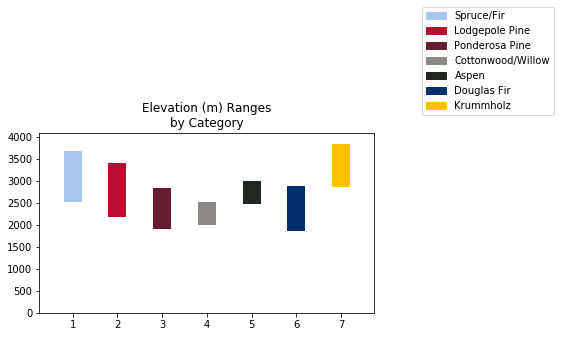

In [14]:
'''Elevations - Ranges'''
elevations_low, elevations_high, elevations_means = get_ranges(full_data, 'Cover_Type', 'Elevation')
elevation_range_titles = {1: 'Elevation (m) Ranges\nby Category', 'figtitle': ''}
elevation_list = [[elevations_low, elevations_high, elevations_means]]
make_range_chart(elevation_list, color_dict,
                 elevation_range_titles, 1, True, 7, False,
                 save='imgs/elevationRanges.png');

'Elevations - Quartiles'

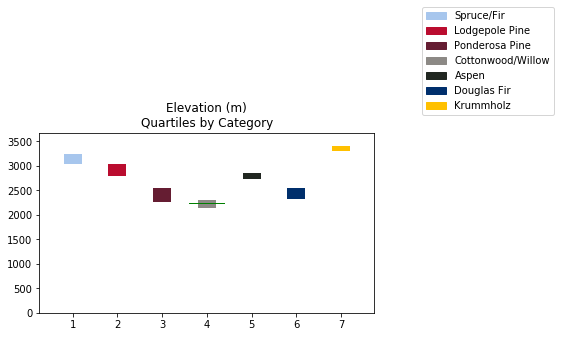

In [15]:
'''Elevations - Quartiles'''
elevations_q1, elevations_q3, elevations_medians = get_quartiles(full_data, 'Cover_Type', 'Elevation')
elevation_quartile_titles = {1: 'Elevation (m)\nQuartiles by Category', 'figtitle': ''}
elevation_quartiles = [[elevations_q1, elevations_q3, elevations_medians]]
make_range_chart(elevation_quartiles, color_dict,
                 elevation_quartile_titles, 1, True, 7, False,
                 save='imgs/elevationQuartiles.png');

### Visualizations: Water

In [16]:
'''Generating the `Euclidean_Distance` variables'''
full_data['Euclidean_Distance_To_Hydrology'] = np.sqrt(full_data['Horizontal_Distance_To_Hydrology']**2 + full_data['Vertical_Distance_To_Hydrology']**2)
full_features['Euclidean_Distance_To_Hydrology'] = np.sqrt(full_features['Horizontal_Distance_To_Hydrology']**2 + full_features['Vertical_Distance_To_Hydrology']**2);

'Generating the `Euclidean_Distance` variables'

'Generating the visualization on the full dataset for EDA'

Text(0.5,1,'Forest cover categorization\nby distance to water and elevation')

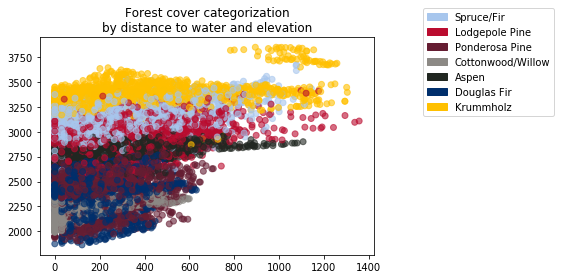

In [17]:
'''Generating the visualization on the full dataset for EDA'''
dist_to_water = full_data['Euclidean_Distance_To_Hydrology']
altitude = full_features['Elevation']
coloration = [color_dict[x] for x in full_labels]
plt.scatter(dist_to_water, altitude, color=coloration, alpha=0.6)
lgd = plt.legend(handles=[cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7],
           bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.title('Forest cover categorization\nby distance to water and elevation')
plt.savefig('imgs/hydrologyAndElevationScatter.png', bbox_extra_artists=(lgd,), bbox_inches='tight');

'Hydrology - Quartiles'

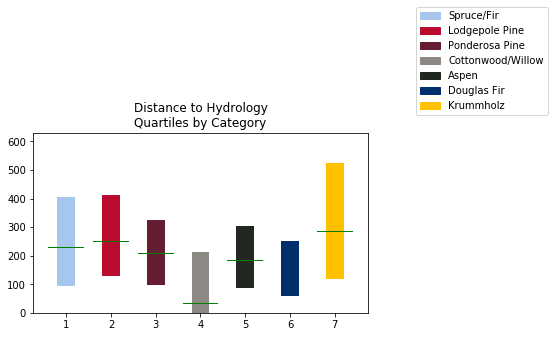

In [18]:
'''Hydrology - Quartiles'''
hydrology_q1, hydrology_q3, hydrology_medians = get_quartiles(full_data, 'Cover_Type', 'Euclidean_Distance_To_Hydrology')
hydrology_quartile_titles = {1: 'Distance to Hydrology\nQuartiles by Category', 'figtitle': ''}
hydrology_quartiles = [[hydrology_q1, hydrology_q3, hydrology_medians]]
make_range_chart(hydrology_quartiles, color_dict,
                 hydrology_quartile_titles, 1, True, 7, False,
                 save='imgs/hydrologyQuartiles.png');

### Visualizations: Hillshade

,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Total_Hillshade
Id,,,,
1,221,232,148,601
2,220,235,151,606
3,234,238,135,607
4,238,238,122,598
5,220,234,150,604
6,230,237,140,607
7,222,225,138,585
8,222,230,144,596
9,223,221,133,577


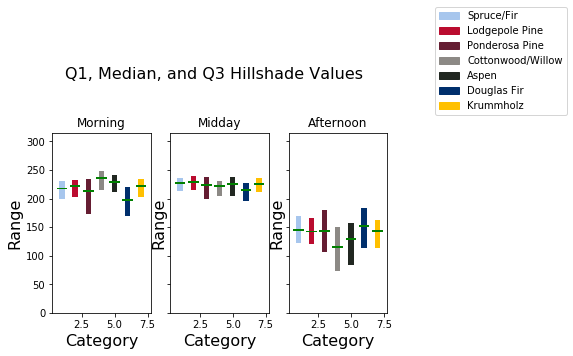

In [19]:
full_data['Total_Hillshade'] = full_data[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].sum(axis=1)
full_features['Total_Hillshade'] = full_features[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].sum(axis=1)
full_data[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm','Total_Hillshade']].head(20)

total_q1, total_q3, total_q2 = get_quartiles(full_data, 'Cover_Type', 'Total_Hillshade')
morning_q1, morning_q3, morning_q2 = get_quartiles(full_data, 'Cover_Type', 'Hillshade_9am')
midday_q1, midday_q3, midday_q2 = get_quartiles(full_data, 'Cover_Type', 'Hillshade_Noon')
afternoon_q1, afternoon_q3, afternoon_q2 = get_quartiles(full_data, 'Cover_Type', 'Hillshade_3pm')

hillshade_quartiles_titles = {0: 'Morning',
                    1: 'Midday',
                    2: 'Afternoon',
                    'figtitle': 'Q1, Median, and Q3 Hillshade Values'}

hillshade_quartiles_list = [[morning_q1, morning_q3, morning_q2],
                  [midday_q1, midday_q3, midday_q2],
                  [afternoon_q1, afternoon_q3, afternoon_q2]]

make_range_chart(hillshade_quartiles_list, color_dict,
                 hillshade_quartiles_titles, 1, True, 7,
                 save='imgs/hillshadeQuartiles.png');

### Visualizations - Aspect

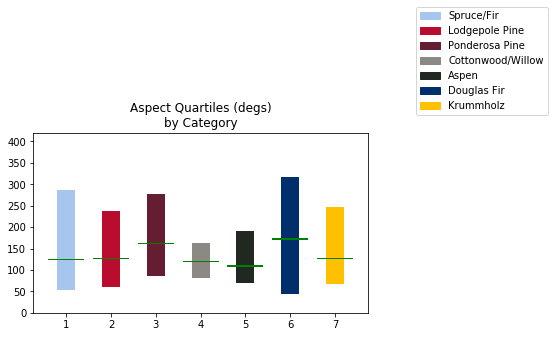

In [20]:
aspects_low, aspects_high, aspects_means = get_quartiles(full_data, 'Cover_Type', 'Aspect')
aspect_range_titles = {1: f'Aspect Quartiles (degs)\nby Category', 'figtitle': ''}
aspect_list = [[aspects_low, aspects_high, aspects_means]]
make_range_chart(aspect_list, color_dict,
                 aspect_range_titles, 1, True, 7, False,
                 save='imgs/aspectsQuartiles.png');

### Visualizations - Slope

Text(0.5,1,'Slope Quartiles\nby Category')

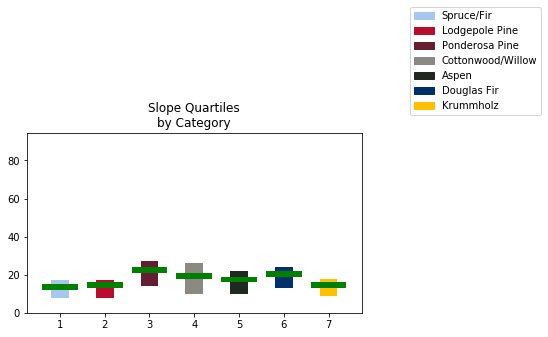

In [21]:
slopes_low, slopes_high, slopes_means = get_quartiles(full_data, 'Cover_Type', 'Slope')
slope_range_titles = {1: f'Slope Range (degs)\nby Category', 'figtitle': ''}
slope_list = [slopes_low, slopes_high, slopes_means]
# make_range_chart(slope_list, color_dict,
#                  slope_range_titles, 1, True, 7, False,
#                  save='imgs/slopesQuartiles.png')
fig, axs = plt.subplots(ncols=1, nrows=1, sharey=True)
data_list = slope_list
base = np.asarray(data_list[0])
middle = np.asarray(data_list[1] - data_list[0])
top = 90
ceiling = np.asarray(top - data_list[1])
mean = np.asarray(data_list[2])

ind = range(1, 8)
width = 0.4
coloration = [color_dict[x] for x in ind]
p1 = plt.bar(ind, base, width, color='w')
p2 = plt.bar(ind, middle, width, bottom=base, color=coloration)
p3 = plt.bar(ind, ceiling, width, bottom=(base+middle), color='w')
p4 = plt.bar(ind, 3, bottom=mean, color='g')
plt.title('Slope Quartiles\nby Category')

plt.subplots_adjust(top=0.75)
lgd = plt.legend(handles=[cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7],
           bbox_to_anchor=(1, 1), loc='center left',
           bbox_transform=plt.gcf().transFigure)
plt.savefig('imgs/slopeQuartiles.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show();

## PCA Feature Engineering


### Hillshade and Aspect

Text(0.5,1,'Elevation vs 1st Principal Component\nof Morning, Afternoon Hillshade and Aspect')

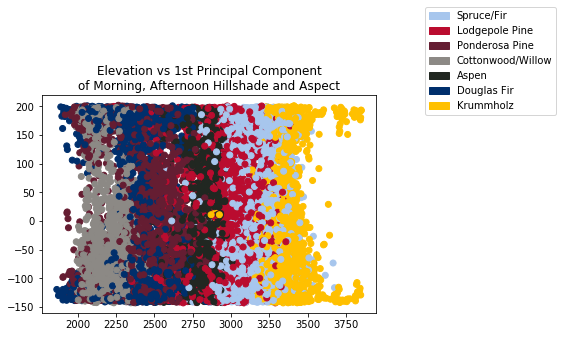

In [22]:
hillshadeAspectPca = PCA(n_components=1)
data = full_data[['Hillshade_3pm', 'Hillshade_9am', 'Aspect']]
Y = hillshadeAspectPca.fit_transform(data)
coloration = [color_dict[x] for x in full_labels]
# print(data.shape, Y.shape, full_data['Elevation'].shape)
plt.scatter(full_data['Elevation'], Y, color=coloration)
plt.title('Elevation vs 1st Principal Component\nof Morning, Afternoon Hillshade and Aspect')
lgd = plt.legend(handles=[cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7],
           bbox_to_anchor=(1, 1), loc='center left',
           bbox_transform=plt.gcf().transFigure)
plt.savefig('imgs/hillshadeAspectPcaScatter.png', bbox_extra_artists=(lgd,), bbox_inches='tight');

### Scatterplot Matrix

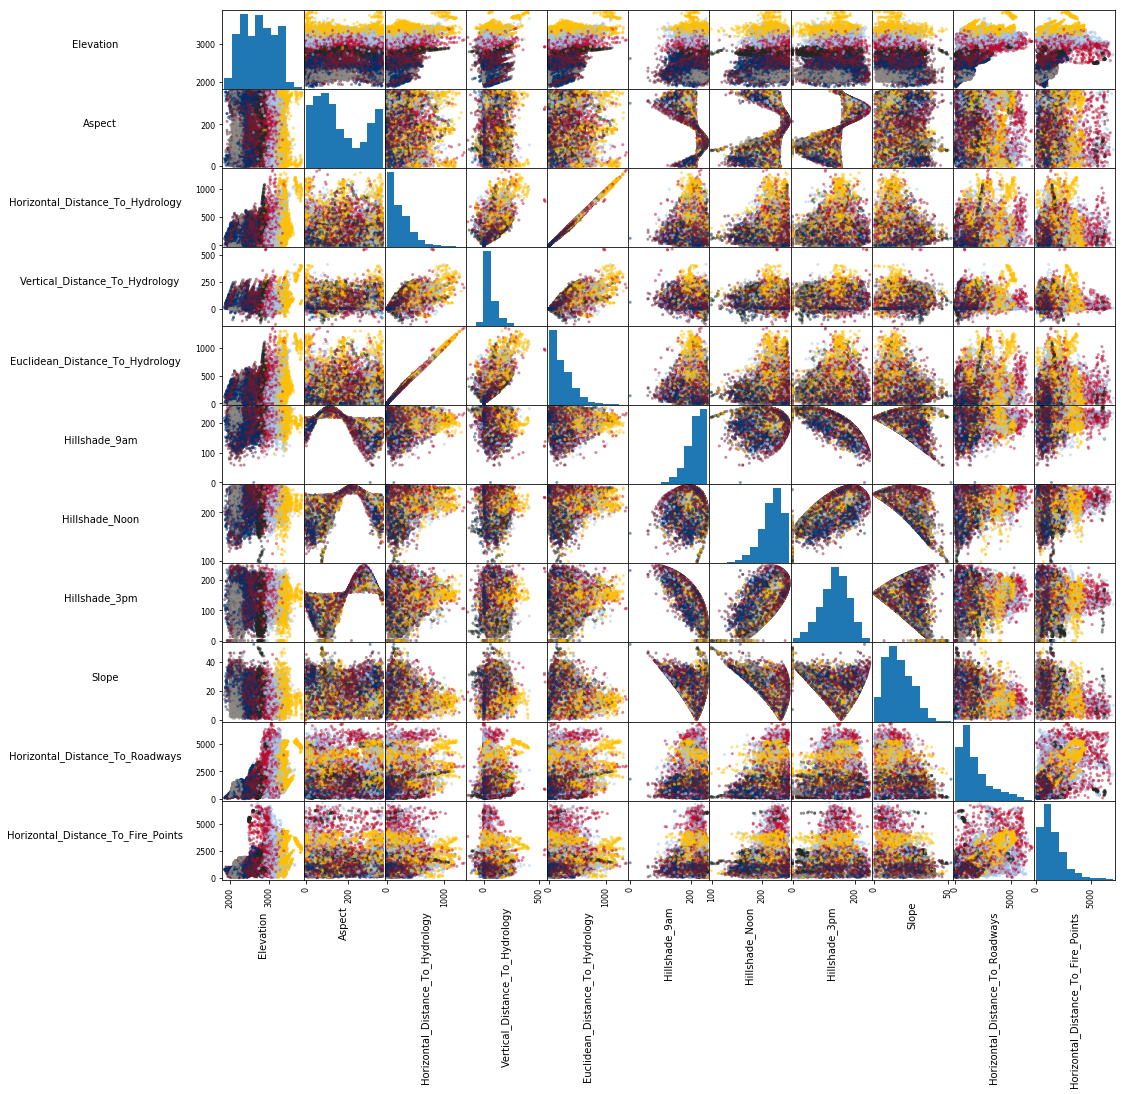

In [23]:
df_to_scatterplot = full_data[['Elevation','Aspect',
                               'Horizontal_Distance_To_Hydrology',
                               'Vertical_Distance_To_Hydrology',
                               'Euclidean_Distance_To_Hydrology',
                               'Hillshade_9am', 'Hillshade_Noon',
                               'Hillshade_3pm', 'Slope',
                               'Horizontal_Distance_To_Roadways',
                               'Horizontal_Distance_To_Fire_Points']]
coloration = [color_dict[x] for x in full_labels]
axs = pd.plotting.scatter_matrix(df_to_scatterplot, figsize=(16, 16), color=coloration)
n = len(df_to_scatterplot.columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 100
plt.savefig('imgs/scatterplotMatrixElevationAspectWaterHillshade.png', bbox_inches='tight')

### Checking Label Balance

In [ ]:
def check_label_balance(train, test):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), sharey=True)
    bins = np.arange(8) + 0.5
    colors = ['cyan', 'red', 'purple', 'gray', 'black', 'blue', 'yellow', 'green']
    _, _, patches = ax1.hist(train, bins, width = 0.8)
    for i in range(len(patches)):
        patches[i].set_fc(colors[i])
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax1.set_title('Labels')
    _, _, patches = ax2.hist(test, bins, width = 0.8)
    for i in range(len(patches)):
        patches[i].set_fc(colors[i])
    ax2.set_title('Test Labels')
    plt.xticks(range(8))
    plt.show()

### Confusion Matrix

In [122]:
def get_confusion_matrix(predY, trueY, f, ax):
    matrix = confusion_matrix(predY, trueY)
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    # plot the matrix per se
    im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

    # plot colorbar to the right
    f.colorbar(im, ax=ax)
    fmt = 'd'

    # write the number of predictions in each bucket
    thresh = matrix.max() / 2.
    for i, j in product(range(matrix.shape[0]), range(matrix.shape[1])):

        # if background is dark, use a white number, and vice-versa
        ax.text(j, i, format(matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if matrix[i, j] > thresh else "black")

    tick_marks = np.arange(len(label_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(label_names.values(), rotation=90,size=8)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(label_names.values(),size=8)
    ax.set_ylabel('True label',size=14)
    ax.set_xlabel('Predicted label',size=14)

    return ax

### Precision vs Recall

In [129]:
def within_model_scatter(model_results, f, ax, 
                          color_dict=color_dict, marker_dict=marker_dict,
                          alpha=1.0,
                          filename=None):
    # There are micro, macro, and weighted avgs too
    model_ct = len(model_results) + 3
    i = 1
    for model in model_results.keys():
        category = model_results[model]
        fold_ct = len(category['f1-score'])
        X, Y, f1 = category['precision'], category['recall'], category['f1-score']
        ax.set_xlabel('Precision', fontsize=16)
        ax.set_xlim((0.4,1.0))
        ax.set_ylabel('Recall', fontsize=16)
        ax.set_ylim((0.4,1.0))
        ax.scatter(X, Y, c=color_dict[model], marker=marker_dict[model][0], s=marker_dict[model][1]*8, alpha=alpha)
        
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", linewidth=0.5, color='black')
    ax.legend(handles=[cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7, cat_macro, cat_micro, cat_weighted],
           bbox_to_anchor=(1, 0.5), loc='center left',
           bbox_transform=plt.gcf().transFigure)
    return ax


### Model Analysis

In [121]:
def model_analysis(model, X_train, y_train, X_test, title_text='NameNotGiven', save=None):
    f, (ax1, ax2) = plt.subplots(1,2)
    f.tight_layout()
    f.set_figheight(5)
    f.set_figwidth(12)
    f.suptitle(title_text, fontsize=24, y=1.1, x=0.7)
    f.subplots_adjust(wspace=0.5)

    model.fit(X_train, y_train)
    pred_y = model.predict(X_test)
    confMatrix = get_confusion_matrix(pred_y, y_test, f, ax1)

    modelResults = cross_validate_model(model, X_train, y_train, name='Logistic Regression', return_dict=True, silent=True)
    scatter = within_model_scatter(modelResults, f, ax2)
    plt.show()
    
    if save is not None:
        f.savefig("imgs/" + save, bbox_extra_artists=(lgd,), bbox_inches='tight')

### Model Comparison

In [ ]:
def compareModel_summary(model_results, title_text='NameNotGiven',
                          color_dict=color_dict, marker_dict=marker_dict,
                          alpha=1.0, share_y=True, multiplier=1, width=0.4,
                          orientation='Wide', range0to1=False, sds=1,
                          verbose=False, save=None, show_legend=True):
    
#     fig = plt.figure(figsize=(8,4))

    # There are micro, macro, and weighted avgs too
    model_ct = len(model_results) + 3
    
    # Initiating figure
    if orientation == 'Wide':
        w, h = figaspect(0.5) * multiplier # Two across
        fig, axs = plt.subplots(figsize=(w,h), ncols=2, nrows=1, sharey=share_y)
    elif orientation == 'Tall':
        w, h = figaspect(2) * multiplier # Two across
        fig, axs = plt.subplots(figsize=(w,h), ncols=1, nrows=2, sharey=share_y)
        
    # Storing F1-scores and standard deviations for second plot
    f1s = []
    std_devs = []
    i = 0
    fig.sca(axs[i])
    
    # Scatterplot of Recall vs. Precision for each result
    for model in model_results.keys():
        cover_type = model_results[model]
        f1s.append(np.mean(cover_type['f1-score']))
        std_devs.append(np.std(cover_type['f1-score']))
        if verbose:
            print(f'For {model}: f-1 scores: {cover_type["f1-score"]}\n' +
                  f'f1s are now: {f1s}\n' +
                  f'std_devs are now: {std_devs}')
        fold_ct = len(cover_type['f1-score'])
        X, Y, f1 = cover_type['precision'], cover_type['recall'], cover_type['f1-score']
        plt.xlabel('Precision', fontsize=16)
        plt.ylabel('Recall', fontsize=16)
        if range0to1:
            plt.xlim(0, 1)
            plt.ylim(0, 1)
        plt.scatter(X, Y, c=color_dict[model], marker=marker_dict[model][0], s=marker_dict[model][1]*4, alpha=alpha)
    
    fig.sca(axs[i + 1])
    # Making data lists for the range chart builder
    ctype_ranges = []
    for x in range(1, 8):
        lows = f1s[x-1] - (sds * std_devs[x-1])
        mids = f1s[x-1]
        highs = f1s[x-1] + (sds * std_devs[x-1])
        ctype_ranges.append([lows, mids, highs])
        if verbose:
            print(f'Cover Type ranges: {ctype_ranges}')
    
        # Range chart of F-1 score w. standard deviation for each category
        base = np.asarray(ctype_ranges[x-1][0] - 0)
        middle = np.asarray(ctype_ranges[x-1][1] - ctype_ranges[x-1][0])
        top = 1
        ceiling = np.asarray(top - ctype_ranges[x-1][1])
        if verbose:
            print(f'Base: {base} | Middle: {middle} | Top: {top} | Ceiling: {ceiling}')

        p1 = plt.bar(x, base, width, color='w')
        p2 = plt.bar(x, middle, width, bottom=base, color=color_dict[x])
        p3 = plt.bar(x, ceiling, width, bottom=(base+middle), color='w')     
    plt.xticks(range(1, 8))
    plt.xlabel('Cover_Type', fontsize=16)
    plt.ylabel(f'F1-Score\n+/- {sds} StdDev', fontsize=16)
    
    fig.suptitle(title_text, fontsize=24)
    plt.subplots_adjust(top=0.85, wspace=0.40, hspace=0.3)
    if show_legend:
        lgd = plt.legend(handles=[cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7, cat_macro, cat_micro, cat_weighted],
               bbox_to_anchor=(1, 1), loc='center left',
               bbox_transform=plt.gcf().transFigure)
        if save is not None:
            plt.savefig(save, bbox_extra_artists=(lgd,), bbox_inches='tight')        
    else:
        if save is not None:
            plt.savefig(save, bbox_inches='tight')        

In [ ]:
# ''' This code was an attempt at figuring out how to lay out an arbitrary number of 
#     model cross-validation graphs. Never got it to work quite right. Commenting it out.
# '''

# # %%debug
# # from itertools import product

# spec_dict = {1:  {'model_results': random_forest, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Random Forest'},
#              2:  {'model_results': support_vector, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Support Vector Machine'},
#              3:  {'model_results': knn3, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': '3-Nearest Neighbors'},
#              4:  {'model_results': logistic, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Logistic Regression'},
#              5:  {'model_results': random_forest, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Random Forest'},
#              6:  {'model_results': support_vector, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Support Vector Machine'},
#              7:  {'model_results': knn3, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': '3-Nearest Neighbors'},
#              8:  {'model_results': logistic, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Logistic Regression'},
#              9:  {'model_results': random_forest, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Random Forest'},
#              10: {'model_results': support_vector, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Support Vector Machine'},
#              11: {'model_results': knn3, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': '3-Nearest Neighbors'},
#              12: {'model_results': logistic, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Logistic Regression'},
#              13: {'model_results': random_forest, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Random Forest'},
#              14: {'model_results': support_vector, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Support Vector Machine'},
#              15: {'model_results': knn3, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': '3-Nearest Neighbors'},
#              16: {'model_results': logistic, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Logistic Regression'}}

# # for result in spec_dict.keys():
# #     withinModel_summary(**spec_dict[result])

# fig11 = plt.figure(figsize=(8, 8), constrained_layout=False)
# # gridspec inside gridspec
# outer_grid = fig11.add_gridspec(4, 4, wspace=0.0, hspace=0.0)
# for i in range(16):
#     inner_grid = outer_grid[i].subgridspec(3, 3, wspace=0.0, hspace=0.0)
#     a, b = int(i/4)+1, i % 4+1
#     for j, (c, d) in enumerate(product(range(1, 4), repeat=2)):
#         ax = plt.Subplot(fig11, inner_grid[j])
#         ax.plot(withinModel_summary(**spec_dict[i+1]))
#         print('made it here')
# #         ax.set_xticks([])
# #         ax.set_yticks([])
#         fig11.add_subplot(ax)
    
# all_axes = fig11.get_axes()

# # # show only the outside spines
# # for ax in all_axes:
# #     for sp in ax.spines.values():
# #         sp.set_visible(False)
# #     if ax.is_first_row():
# #         ax.spines['top'].set_visible(True)
# #     if ax.is_last_row():
# #         ax.spines['bottom'].set_visible(True)
# #     if ax.is_first_col():
# #         ax.spines['left'].set_visible(True)
# #     if ax.is_last_col():
# #         ax.spines['right'].set_visible(True)
# # plt.show()

In [ ]:
# ''' This code does not work quite the way I would like. Commenting it out for now. -TS'''
# small_dict = {1:  {'model_results': random_forest, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Random Forest'},
#              2:  {'model_results': support_vector, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Support Vector Machine'},
#              3:  {'model_results': knn3, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': '3-Nearest Neighbors'},
#              4:  {'model_results': logistic, 'verbose': False, 'share_y': False, 'range0to1': True, 'orientation': 'Tall', 'title_text': 'Logistic Regression'}}

# def group_results_dicts(results_dict):
#     model_ct = len(results_dict.keys())
#     w, h = figaspect(2) * model_ct
#     fig, axs = plt.subplots(figsize=(w,h), ncols=model_ct, nrows=1, sharey=False)
#     for i in range(1, model_ct+1):
# #         plt.sca(1, model_ct, i)
#         fig.sca(axs[i-1])
#         withinModel_summary(**results_dict[i])

In [ ]:
# Flooowing code has been tried out with multiple options:
# - Engineeered vs. non-engineered datasets
# - Scaled vs. non-scaled train/test datasets
# - Different model combinations
# - Gridseasrch for best hyper parameters

#from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import VotingClassifier
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
#from sklearn.neural_network import MLPClassifier
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from sklearn.model_selection import cross_val_score

##clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial',random_state=1)
#clf1 =LinearSVC()
#clf2 = RandomForestClassifier()
#clf3 = GaussianNB()
#clf4 = KNeighborsClassifier()
#clf5 = SVC(gamma=2, C=1)
#clf6 = GaussianProcessClassifier(1.0 * RBF(1.0))
#clf7 = MLPClassifier(alpha=1,activation = 'tanh',solver = 'lbfgs' )
##clf8 = AdaBoostClassifier()
#clf8 = XGBClassifier(max_depth=10, learning_rate=0.3, n_estimators=200, n_jobs=4)
#clf9 = QuadraticDiscriminantAnalysis()
#eclf = VotingClassifier(estimators=[
##                                    ('lsvc', clf1)
##                                    , 
##                                    ('rf', clf2)
##                                    , ('gnb', clf3)
##                                   , 
#                                    ('knn', clf4)
##                                   , ('svc', clf5)
##                                   , ('gpc', clf6)
##                                   , ('mlp', clf7)
#                                   , ('GB', clf8)
##                                   , ('qda', clf9)
#                                   ], voting='hard')
#
#params = {
#    #    'lsvc__C': [1.0, 100.0], 
#    "knn__n_neighbors":[3,5,7,],"knn__weights":["uniform","distance"],
#         # 'rf__n_estimators': [5, 10], "rf__criterion": ["gini", "entropy"], "rf__min_samples_split":[5,7,10]
#     }
#
##model = GridSearchCV(estimator=eclf, param_grid=params, cv=5)

##model.fit(scaled_FX_train, Fy_train)
##testPrediction = model.predict(scaled_FX_test)
#model.fit(e_X_train, e_y_train)
#testPrediction = model.predict(e_X_test)
##model.fit(X_train, y_train)
##testPrediction = model.predict(X_test)
#testReport = metrics.classification_report(testPrediction, e_y_test, output_dict=True)
#verbose= True

#reportFields = ['precision', 'recall', 'f1-score']
#fields = sorted(testReport.keys()) if verbose else ['weighted avg']
#fieldLabels = [label_names[field] if field in label_names.keys() else field for field in fields]
#fieldLabels[-1] = "Final"

#for i in range(len(fields)):
#    output = f'\t\t{fieldLabels[i]:<20} | '
#    for outputField in reportFields:
#        output += f'{outputField}: {np.mean(testReport[fields[i]][outputField]):>5.2f} | '
#    print(output)
#for clf, label in zip([
#            #clf1,
#            #clf2, clf3, 
#            clf4
#            #, clf5,clf6,clf7
#            ,clf8
#            #,clf9
#            , eclf]
#            , [ 
#                #"LinearSVC",
#                #"RandomForestClassifier"
#                #,"GaussianNB()",
#                "KNeighborsClassifier"
#                #,"SVC","GaussianProcessClassifier"
#                #,"MLPClassifier"
#                ,"GB"
#                #,"QuadraticDiscriminantAnalysis"
#                ,"Ensemble"]):
#     scores = cross_val_score(clf, e_X_train, e_y_train, cv=5, scoring='accuracy')
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label)) 

In [ ]:
def e_feat(in_df):
    e_data = copy.deepcopy(in_df)
    e_data["Soil_class_1"] = e_data.loc[:,"Soil_Type1":"Soil_Type18"].sum(axis = 1)
    e_data["Soil_class_2"] = e_data.loc[:,"Soil_Type19":"Soil_Type28"].sum(axis = 1)
    e_data["Soil_class_3"] = e_data.loc[:,"Soil_Type29":"Soil_Type34"].sum(axis = 1)
    e_data["Soil_class_4"] = e_data.loc[:,"Soil_Type35":"Soil_Type40"].sum(axis = 1)
    #e_data["Alt_sq"] = e_data['Elevation']**2
    #e_data["Elevation_Of_Hydrology_sq"] = e_data['Elevation_Of_Hydrology']**2
    e_data.drop([ 
            #'Wilderness_Area1','Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
           'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
           'Soil_Type6'
            #, 'Soil_Type7'
            , 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
           'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14'
           #,'Soil_Type15'
            , 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
           'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
           'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
           'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
           'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
           'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
           'Soil_Type39', 'Soil_Type40'
            #,'Elevation_Of_Hydrology'
            #, 'Cover_Type'
            ],axis = 1,inplace=True)
    return(e_data)